In [16]:
import os
import torch
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from PIL import Image

# from model2 import UNet, FCRN_A, UNet_full
from scipy.ndimage import gaussian_filter
from skimage import color, morphology
from scipy.ndimage import label, generate_binary_structure

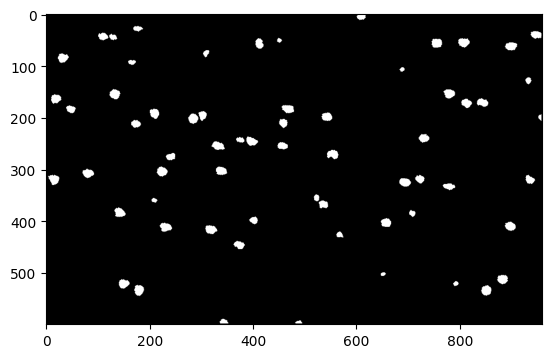

In [4]:
image = np.array(Image.open("/home/huyentn2/huyen/project/Weinan_prediction/output_v20_png/3min_0am375_newsilaneAPTES_ACN_DSC_watercapture1_6NP_0.png"))

plt.imshow(image, cmap='gray')

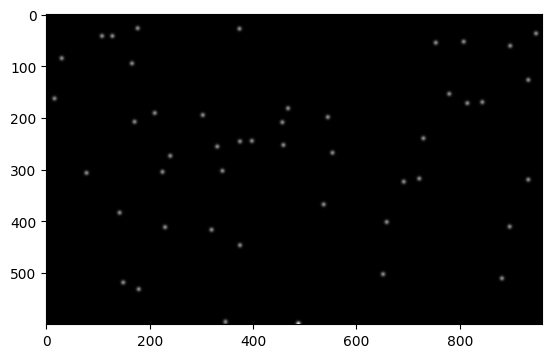

In [33]:
GT = np.array(Image.open("/home/huyentn2/huyen/project/Weinan_prediction/ground_truth/save_mask/3min_0am375_newsilaneAPTES_ACN_DSC_watercapture1_6NP_0.png"))

GT_map = gaussian_filter((GT>0)*100.0, sigma=(3, 3), order=0)

plt.imshow(GT_map, cmap='gray')

In [14]:
img = Image.open("/home/huyentn2/huyen/project/Weinan_prediction/ground_truth/save_patch/3min_0am375_newsilaneAPTES_ACN_DSC_watercapture1_6NP_0.png")



image = Image.open("/home/huyentn2/huyen/project/Weinan_prediction/output_v20_png/3min_0am375_newsilaneAPTES_ACN_DSC_watercapture1_6NP_0.png")


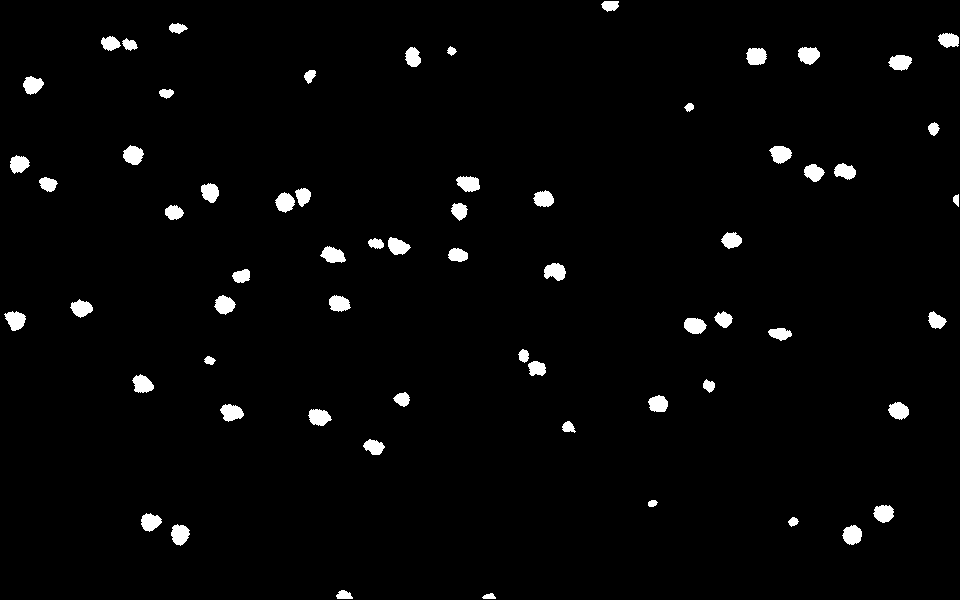

In [15]:
image

In [19]:
# labeled_array, num_features = label(np.array(Image.open("/home/huyentn2/huyen/project/Weinan_prediction/output_v20_png/5 min-0am375_DMSO-capture_1.png")))
# num_features

15

https://stackoverflow.com/questions/56766146/how-to-change-the-colors-of-a-binary-image-using-python

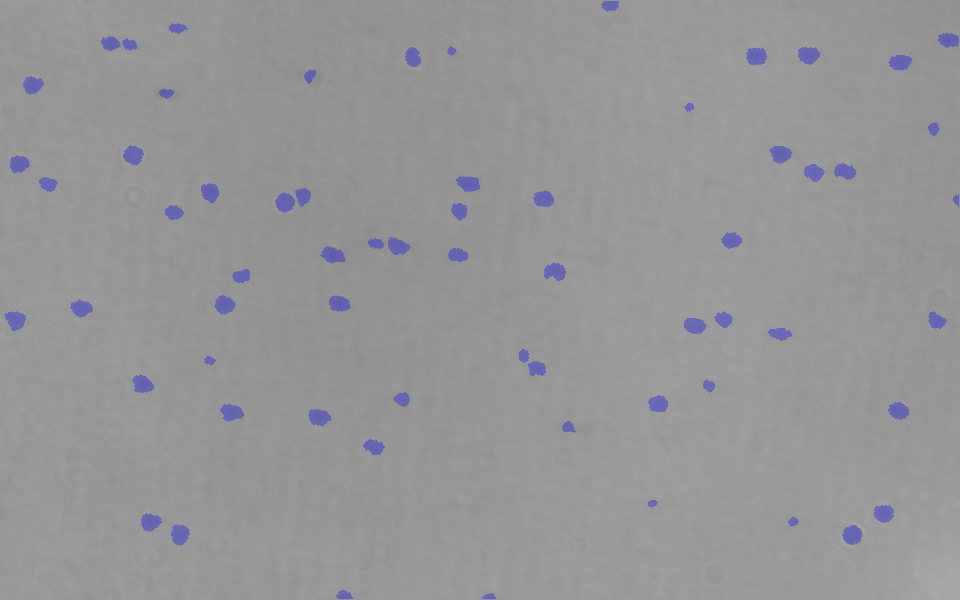

In [71]:
# Make 3 channel RGB image same dimensions
binary = np.array(image)[:,:,0] >0
RGB = np.zeros((binary.shape[0],binary.shape[1],3), dtype=np.uint8)
# Make True pixels red/blue
RGB[binary]  =  [0,0, 255]  # [255,0,0]
# Make False pixels blue
# RGB[~binary] = [0,0,255]
# Display result
# Image.fromarray(RGB)


# radar_bg = image.convert('RGB')
radar_bg = Image.fromarray(RGB)
radar_bg.putalpha(radar_bg.getchannel('B').point(lambda x: x * 0.3))

comp_a = Image.alpha_composite(img.convert('RGBA'), radar_bg)


# basemap = Image.fromarray(GT_map).convert('RGB')
# basemap.putalpha(basemap.convert('L'))
# basemap.putalpha(basemap.getchannel('R').point(lambda x: x * 0.3))
# comp_a = Image.alpha_composite(img.convert('RGBA'), basemap)

comp_a

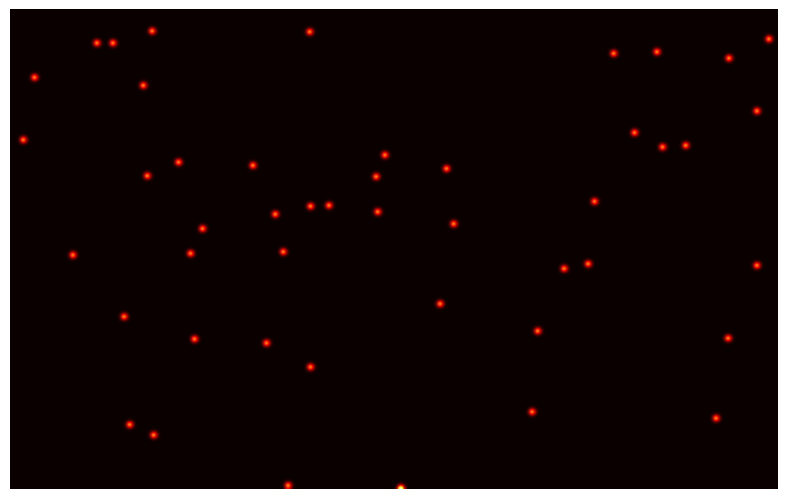

In [74]:
fig, ax = plt.subplots(figsize=figaspect(1.0 * img.size[1] / img.size[0]))
fig.subplots_adjust(0, 0, 1, 1)

# plot a density map without axis
ax.imshow(GT_map, cmap="hot")
plt.axis('off')
# plt.savefig("cell_img2.png")
fig.canvas.draw()

# create a PIL image from a matplotlib figure
dmap = Image.frombytes('RGB',
                        fig.canvas.get_width_height(),
                        fig.canvas.tostring_rgb())

# add a alpha channel proportional to a density map value
dmap.putalpha(dmap.convert('L'))

# display an image with density map put on top of it

# Image.alpha_composite(img.convert('RGBA'), dmap.resize(img.size)).show()

Image.alpha_composite(comp_a, dmap.resize(img.size)).save("vis/3min_0am375_newsilaneAPTES_ACN_DSC_watercapture1_6NP_0_vis.png")


START

In [8]:
import os
import torch
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from PIL import Image

# from model2 import UNet, FCRN_A, UNet_full
from scipy.ndimage import gaussian_filter
from skimage import color, morphology
import json
from scipy.ndimage import label, generate_binary_structure

In [20]:
def single_img(PATH, sv_p):
    img = Image.open(PATH)

    image = Image.open("/home/huyentn2/huyen/project/Weinan_prediction/output_v20_png/" + os.path.basename(PATH))

    GT = np.array(Image.open(PATH.replace("patch", "mask")))

    GT_map = gaussian_filter((GT>0)*100.0, sigma=(3, 3), order=0)

    # Make 3 channel RGB image same dimensions
    binary = np.array(image) >0
    RGB_bg = np.zeros((binary.shape[0],binary.shape[1],3), dtype=np.uint8)
    # Make True pixels red/blue
    RGB_bg[binary]  =  [0,0, 255]  # [255,0,0]
    RGB_bg = Image.fromarray(RGB_bg)
    RGB_bg.putalpha(RGB_bg.getchannel('B').point(lambda x: x * 0.3))
    comp_a = Image.alpha_composite(img.convert('RGBA'), RGB_bg)

    fig, ax = plt.subplots(figsize=figaspect(1.0 * img.size[1] / img.size[0]))
    fig.subplots_adjust(0, 0, 1, 1)

    # plot a density map without axis
    ax.imshow(GT_map, cmap="hot")
    plt.axis('off')
    fig.canvas.draw()
    # create a PIL image from a matplotlib figure
    dmap = Image.frombytes('RGB',
                            fig.canvas.get_width_height(),
                            fig.canvas.tostring_rgb())
    # add a alpha channel proportional to a density map value
    dmap.putalpha(dmap.convert('L'))
    Image.alpha_composite(comp_a, dmap.resize(img.size)).save(sv_p + os.path.basename(PATH))
    _ , num_features = label(np.array(image))

    return GT.sum()/255, num_features

    



In [27]:
def vis(img_list, sv_p):

    count_true = []
    count_pred = []
    for img in img_list:
        c_true, c_pred = single_img(img, sv_p)
        count_true.append(c_true)
        count_pred.append(c_pred)

    fig = plt.figure(figsize=(10,10))
    axs = [plt.subplot(3, 2, 1), plt.subplot(3, 2, 2), plt.subplot(3, 2, 3),
           plt.subplot(3, 2, 4), plt.subplot(3, 2, 5), plt.subplot(3, 2, 6),
          ]
    
    print(count_true)
    print(count_pred)
    
    assert len(img_list) == 3
    for i in range(3):

        image_path = img_list[i]

        axs[2*i].imshow(np.array(Image.open(image_path)), cmap='gray')
        axs[2*i].axis('off')
        axs[2*i+1].imshow(np.array(Image.open(sv_p + os.path.basename(image_path))))
        axs[2*i+1].axis('off')

        axs[2*i +1].set_title("GT: {:.0f},  Pred: {:.0f}".format(count_true[i], count_pred[i]))

    fig.tight_layout()
    plt.show()
    fig.savefig('/home/huyentn2/huyen/project/Weinan_prediction/err_vis.png')

[112.0, 74.0, 124.0]
[5, 58, 6]


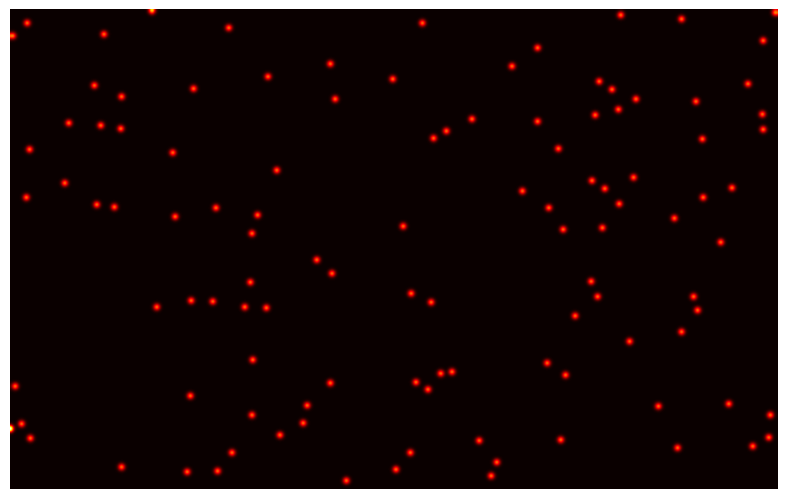

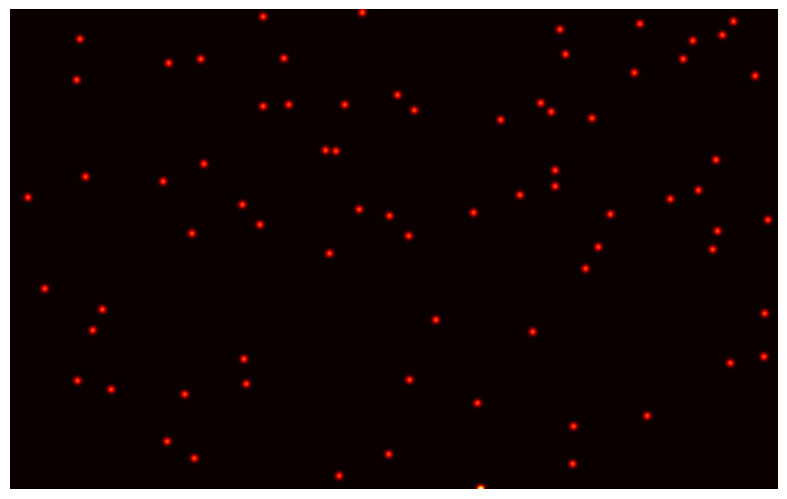

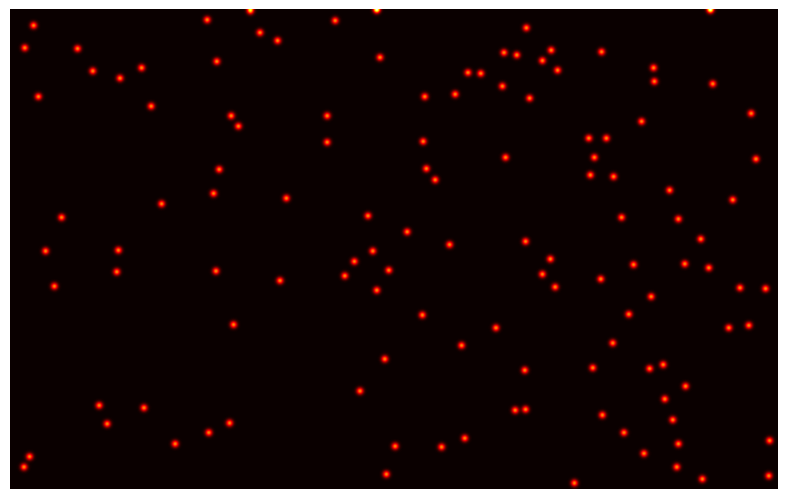

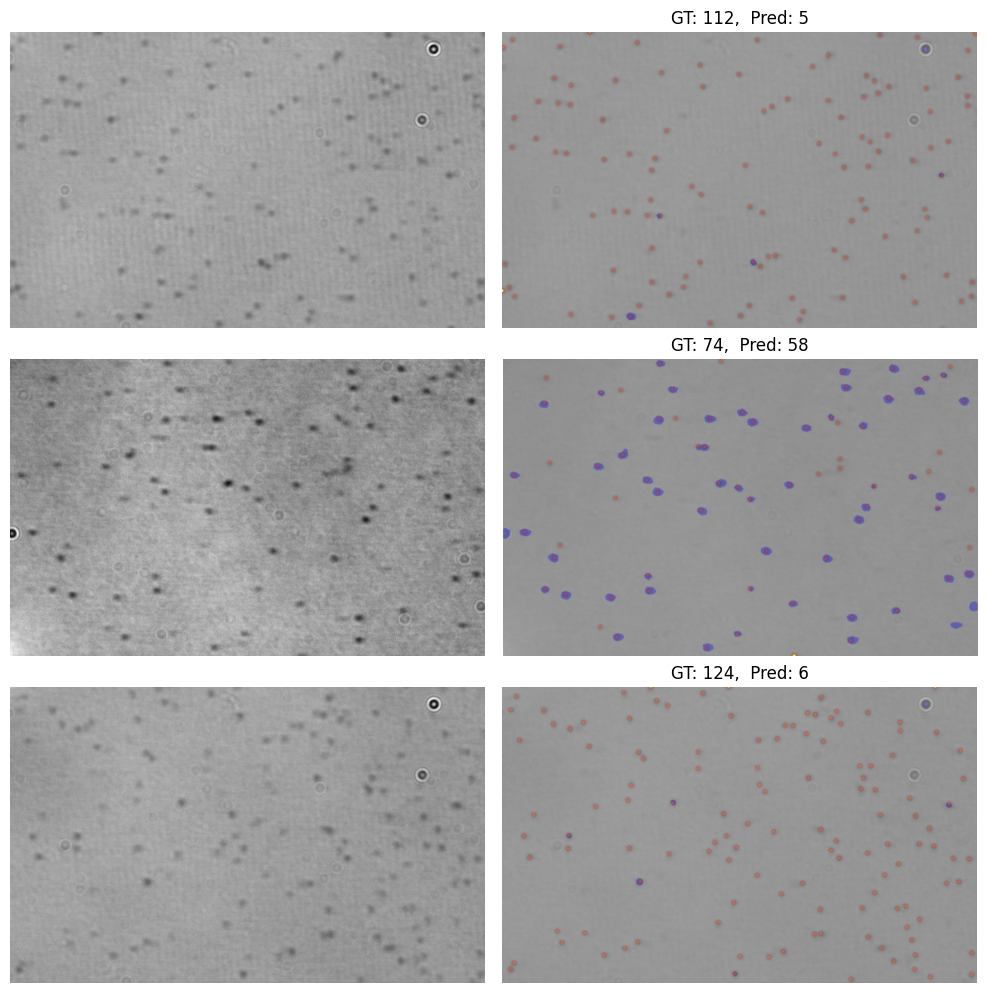

In [28]:
img_list = ["/home/huyentn2/huyen/project/Weinan_prediction/ground_truth/save_patch/5 min-0am375_DIPEA-capture_3.png",
            "/home/huyentn2/huyen/project/Weinan_prediction/ground_truth/save_patch/5min_10fm375_watercapt_toluene_1.png",
            "/home/huyentn2/huyen/project/Weinan_prediction/ground_truth/save_patch/10min--bareNPsonly_10%DMSO_DSC_DIPEAcap_old-1min_1mmMG_3.png"]
sv_p = "/home/huyentn2/huyen/project/Weinan_prediction/vis/"

vis(img_list, sv_p)

In [33]:
def vis_err_scat(fold_l, sv_p):
    count_true_folds = []
    count_pred_folds = []
    for fold in fold_l:
        count_true = []
        count_pred = []

        image_name_fold = json.load(open("/home/huyentn2/huyen/project/Weinan_prediction/out_wein/particle/{}/true_count_fold{}.json".format(fold, fold)))
        for img_path in image_name_fold:

            image = np.array(Image.open("/home/huyentn2/huyen/project/Weinan_prediction/output_v20_png/" + os.path.basename(img_path)))
            _ , num_features = label(np.array(image))

            count_true.append(image_name_fold[img_path])
            count_pred.append(num_features)
        
        count_true_folds.append(count_true)
        count_pred_folds.append(count_pred)


    fig = plt.figure(figsize=(10,10))
    axs = [plt.subplot(2, 2, 1), plt.subplot(2, 2, 2), plt.subplot(2, 2, 3),
           plt.subplot(2, 2, 4), 
          ]
    
    assert len(fold_l) == 4

    for i in range(4):
        err_ct_mean = np.array(count_true_folds[i]) - np.array(count_pred_folds[i])
        true, pred = np.array(count_true_folds[i]), np.array(count_pred_folds[i])
        RE = np.mean(np.abs(err_ct_mean)/ true)

        axs[i].scatter(true, pred, label = "Fold {:.0f}, Mean RE {:.2f}".format(i+1, RE ))
        # axs[i].scatter(true, pred, label = "Mean RE fold {:.0f}: {:.2f}".format(i+1,  RE))
        axs[i].legend()

        z = np.polyfit(true, pred, 1)
        p = np.poly1d(z)
        axs[i].plot(true,p(true),linestyle='dotted', lw=1, color='red')

    fig.supxlabel('Num of true nano-particles in image')
    fig.supylabel('The predicted counts of nao-particles')

    # plt.xlabel("Num of true nano-particles in image")
    # plt.ylabel("The predicted counts of nao-particles")

    fig.tight_layout()
    plt.show()
    fig.savefig('/home/huyentn2/huyen/project/Weinan_prediction/err_vis_scat.png')
    

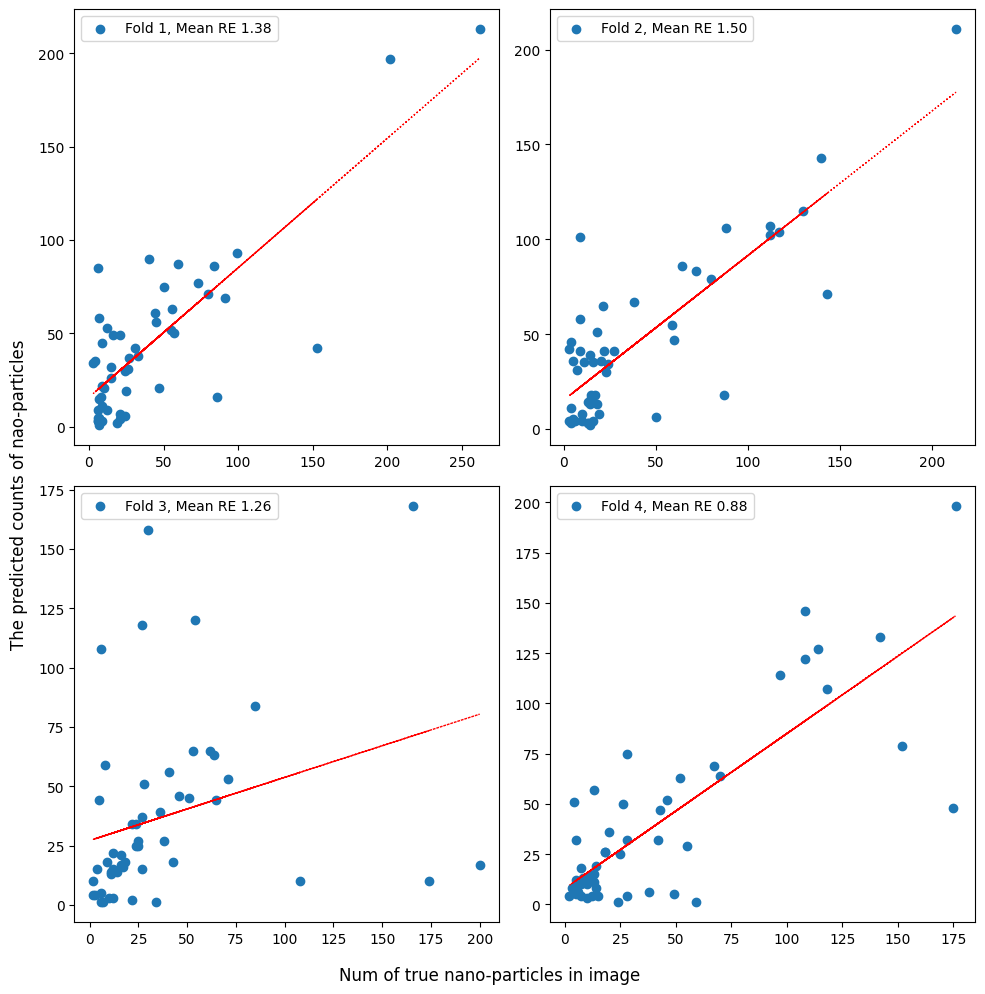

In [34]:
vis_err_scat([1,2,3,4], "")